In [1]:
import _pickle as pickle
import jax
import math
import matplotlib.pyplot as plt
import numpy as np
import os

from jaxl.constants import *
from jaxl.plot_utils import set_size

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
doc_width_pt = 750.0
baseline_path = "/home/bryanpu1/projects/jaxl/scripts/icl/results-num_blocks_8-num_tasks_5-seq_len_16-seed_9999-10-11-23_20_07_56"

context_data = pickle.load(
    open(os.path.join(baseline_path, "context_data.pkl"), "rb")
)

gt = pickle.load(
    open(os.path.join(baseline_path, "ground_truth.pkl"), "rb")
)

agent_reprs = pickle.load(
    open(os.path.join(baseline_path, "agent_reprs.pkl"), "rb")
)

agent_results = pickle.load(
    open(os.path.join(baseline_path, "agents.pkl"), "rb")
)

config = pickle.load(
    open(os.path.join(baseline_path, "config.pkl"), "rb")
)

baseline_results = pickle.load(
    open(os.path.join(baseline_path, "baseline_results.pkl"), "rb")
)

input_range = config["input_range"]

CUDA backend failed to initialize: Unable to load CUDA. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Visualize ICL Transformer

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[1.         1.         2.34116192 1.92049149 1.         3.54735292
 1.03652568 2.17178407 3.88381407 1.69767983 2.97156088 2.61710599
 1.64464002 1.16475681 1.23098893 2.05554239]


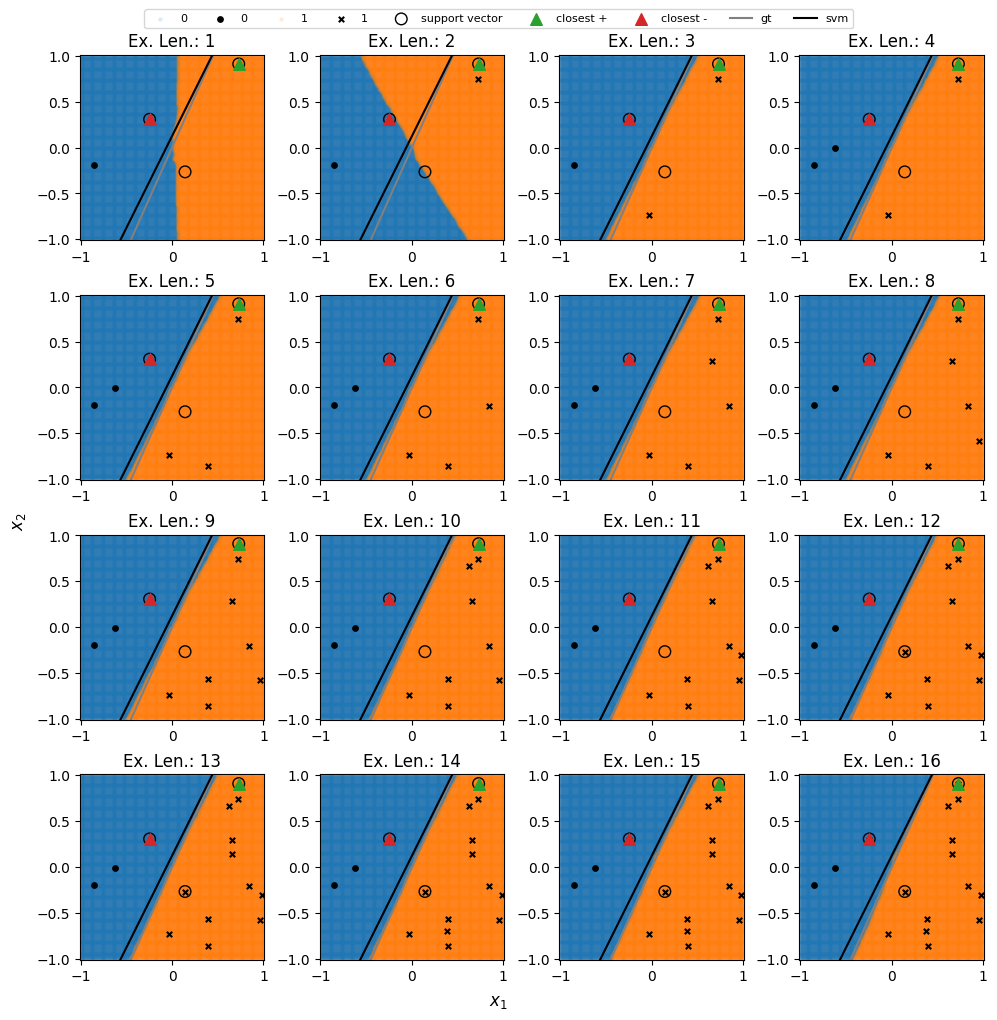

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[2.05788358 1.         1.         4.34558389 1.93565889 2.11133865
 2.67426826 2.59474404 2.6584584  1.         2.89658598 3.75012104
 1.29245381 2.98396877 2.25050003 1.40343512]


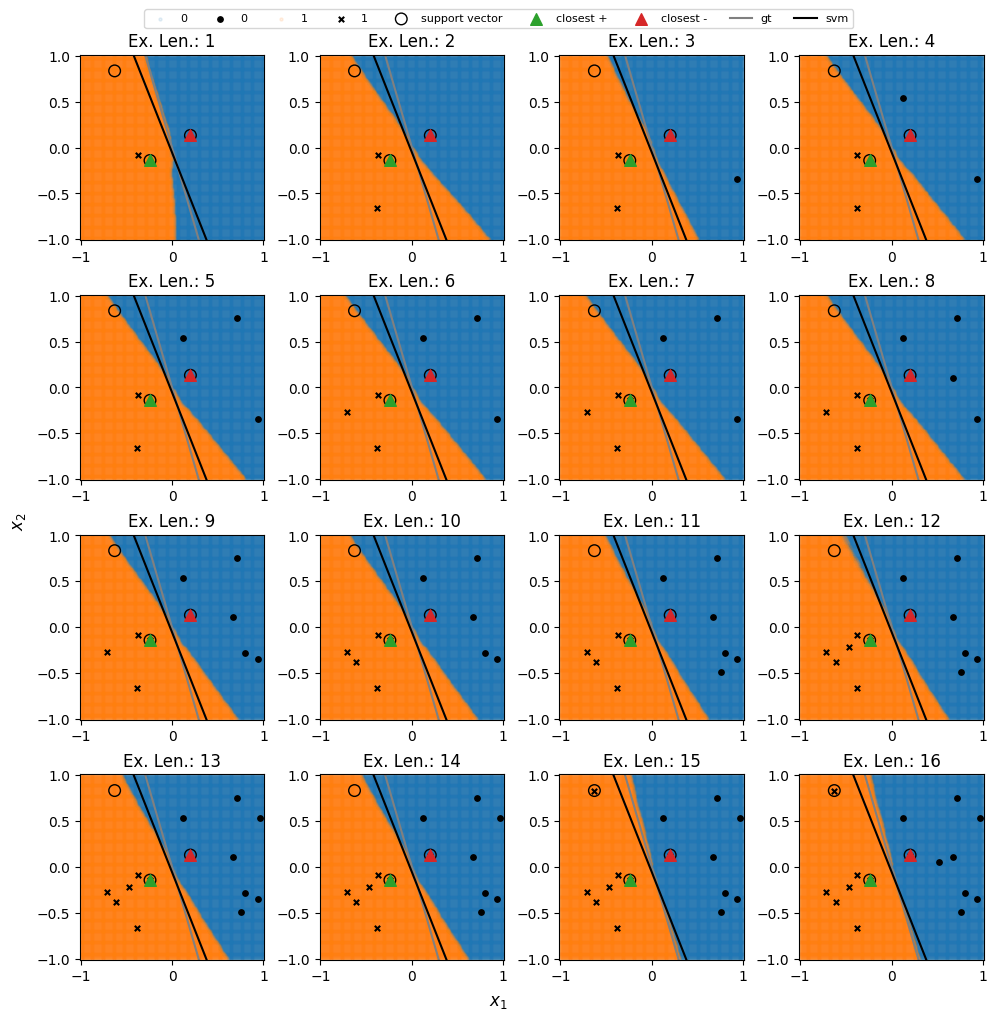

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[4.73479093 1.42929025 3.90808079 1.         2.28568912 1.24177045
 4.99503137 1.2752528  3.13655033 1.         1.         4.6304133
 4.92065297 3.38215688 3.78728563 2.15584476]


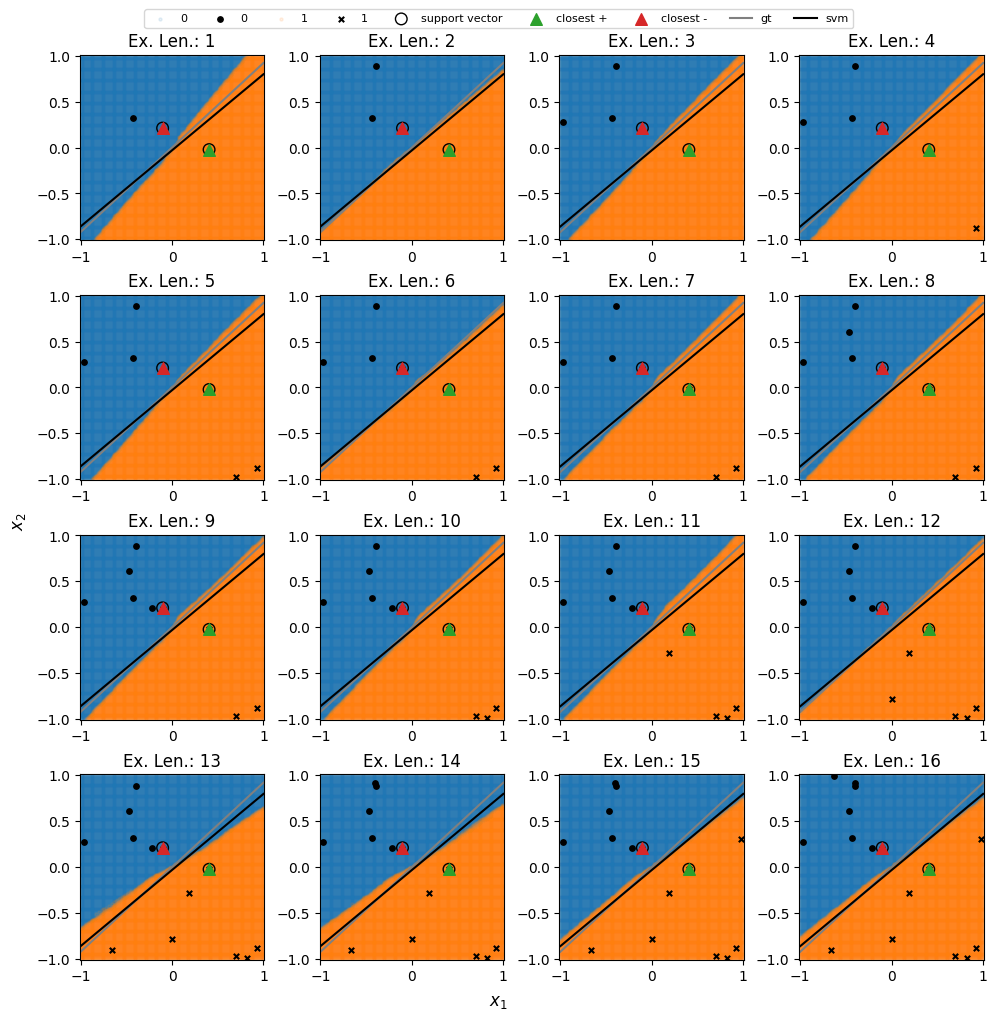

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[2.93056171 1.         3.21467287 2.80397284 3.53442098 2.16726321
 3.61676775 3.96315113 1.         3.52117369 2.36118201 4.3782237
 1.54423483 3.41160407 1.         2.88752503]


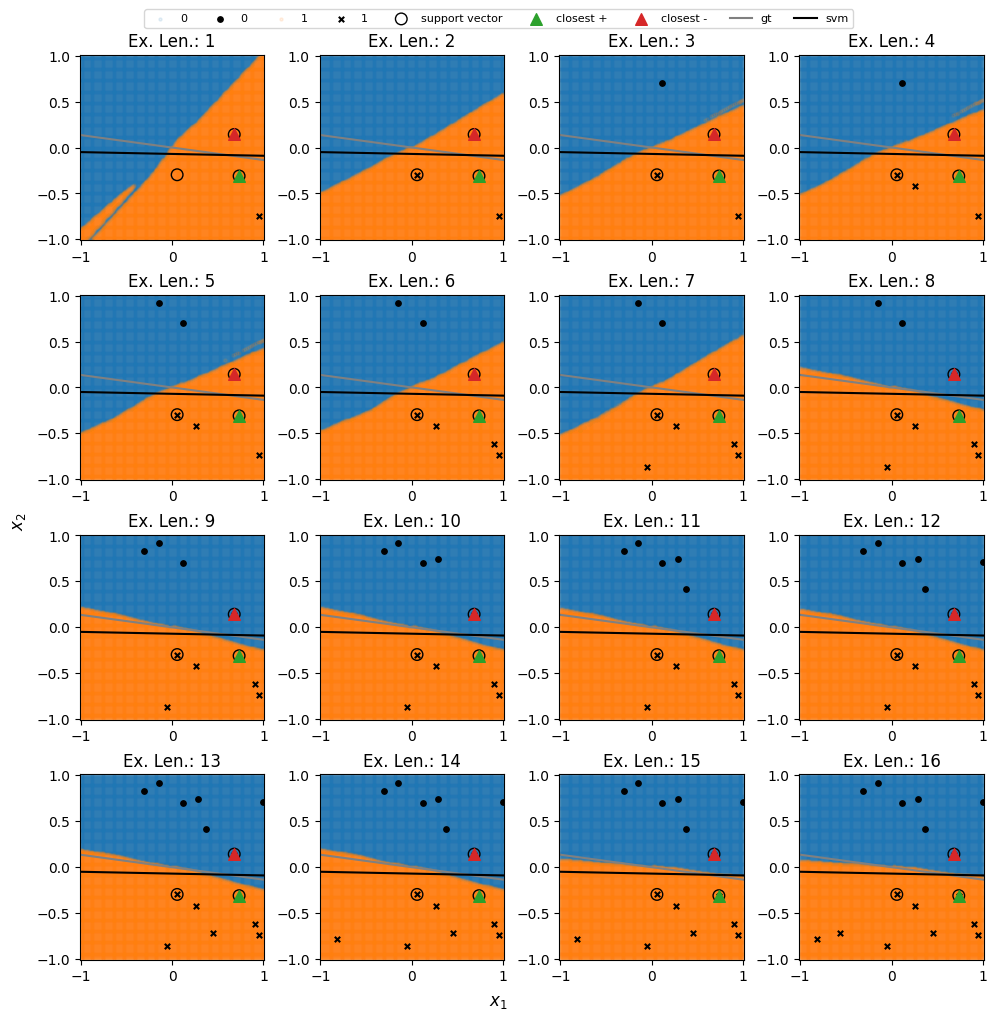

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[2.04890289 1.         2.10054567 1.7868319  1.95984079 1.00292111
 1.50880912 2.17241674 1.62076521 1.         2.5035661  1.61061188
 1.80459919 3.33999559 1.09860689 1.        ]


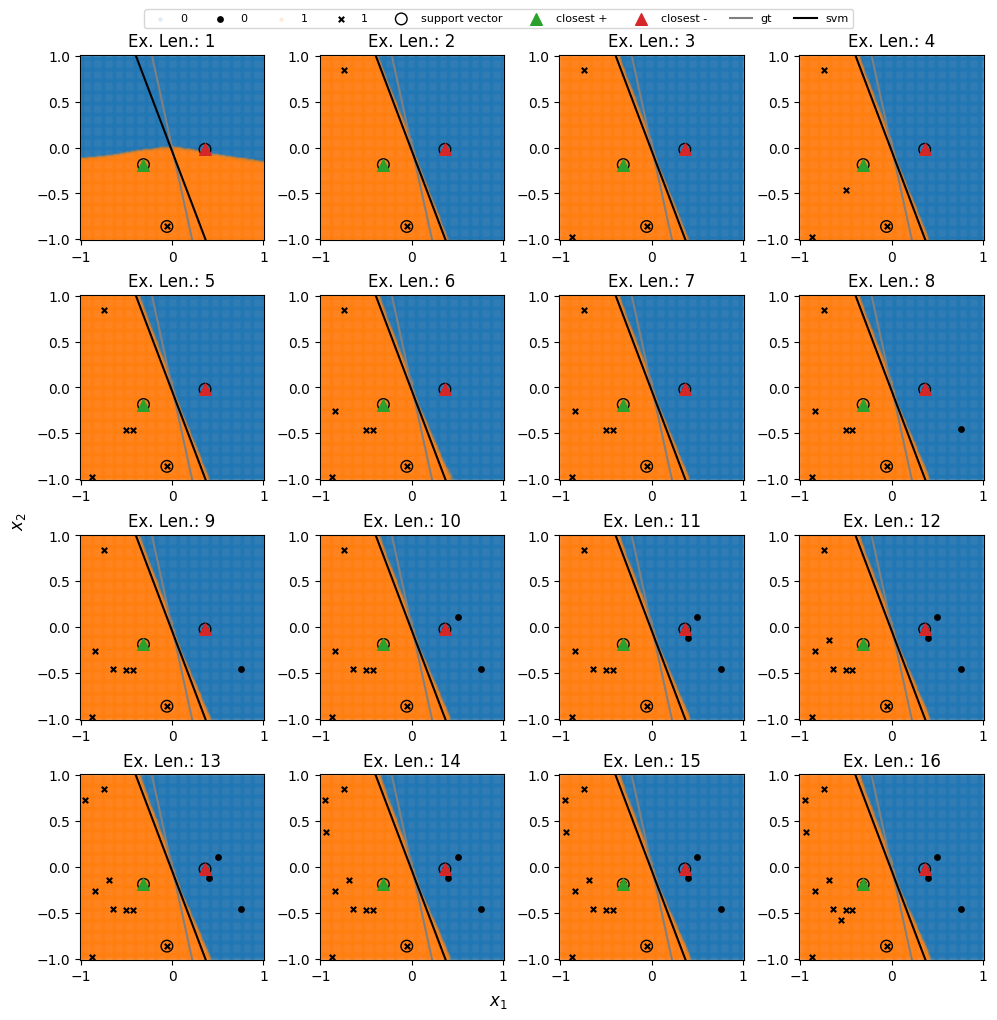

In [3]:
ncols = 4
for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_result in agent_results.items():
        print("Processing agent {}".format(agent_path))

        svm_primal = agent_reprs[agent_path]["svms"][task_i]["input"]["primal"]["sol"]
        svm_db = -(np.array(input_range) * svm_primal[0] + svm_primal[2]) / svm_primal[1]

        primal_out = (context_inputs @ svm_primal[:-1]) + svm_primal[-1]
        primal_constraints = 2 * (0.5 - (1 - train_y)) * primal_out
        print(primal_constraints)
        support_vectors = context_inputs[np.where(primal_constraints <= 1)[0]]

        poss = np.where(primal_out > 0)[0]
        negs = np.where(primal_out < 0)[0]
        closest_pos = context_inputs[poss[np.argmin(primal_out[poss])]]
        closest_neg = context_inputs[negs[np.argmax(primal_out[negs])]]

        per_task_results = agent_result[task_i]
        nrows = math.ceil(len(per_task_results) / ncols)
        fig, axes = plt.subplots(
            nrows,
            ncols,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )
        
        for ax_i, examplar_len in enumerate(per_task_results):
            mask = (np.arange(len(context_inputs)) >= len(context_inputs) - examplar_len)
            if nrows == 1:
                ax = axes[ax_i]
            else:
                ax = axes[ax_i // ncols, ax_i % ncols]
            one_hot_preds = per_task_results[examplar_len]
            preds = np.argmax(one_hot_preds, axis=-1)
            
            for possible_label in [0, 1]:
                idxes = np.where(preds == possible_label)
                ax.scatter(
                    gt["inputs"][idxes][:, 0],
                    gt["inputs"][idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=5,
                    alpha=0.1,
                )
                idxes = np.where(train_y[mask] == possible_label)
                ax.scatter(
                    context_inputs[mask][idxes][:, 0],
                    context_inputs[mask][idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=15,
                    marker="x" if possible_label else "o",
                    c="black"
                )

            ax.scatter(
                support_vectors[:, 0],
                support_vectors[:, 1],
                label=f"support vector" if ax_i == 0 else "",
                s=70,
                facecolors="none",
                edgecolors="black",
            )

            ax.scatter(
                closest_pos[0],
                closest_pos[1],
                label=f"closest +" if ax_i == 0 else "",
                s=70,
                marker="^"
            )

            ax.scatter(
                closest_neg[0],
                closest_neg[1],
                label=f"closest -" if ax_i == 0 else "",
                s=70,
                marker="^"
            )
            
            ax.plot(
                input_range,
                gt["decision_boundary"][task_i],
                color="gray",
                label="gt" if ax_i == 0 else ""
            )
            ax.plot(
                input_range,
                svm_db,
                color="black",
                label="svm" if ax_i == 0 else ""
            )
            ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_title("Ex. Len.: {}".format(examplar_len))
            ax.grid(False)

        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=10,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )
        fig.supxlabel("$x_1$")
        fig.supylabel("$x_2$")
        plt.show()

# Visualize Representation SVM
Visualize SVM trained in the represnetation space induced by the transformer by mapping the SVM prediction back onto the input space.
- `context_reprs` corresponds to the representation induced by feeding in each of the context samples into the query token
- `input_token_context_reprs` corresponds to taking the context token directly

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[ 1.00472674 -1.          1.07815205  1.08676046  1.          1.07953459
  1.04701082  1.06693504  1.08521378  1.07766353  1.07719749  1.07916507
 -1.01064237  1.          1.05062195 -1.00453614]
[ 1.         -1.          2.01125914  3.46520972  1.65278657  2.30851272
  2.07588089  2.23796618  2.31468016  2.15730969  2.11327211  2.16322834
 -1.          1.          1.98825819 -1.22207787]


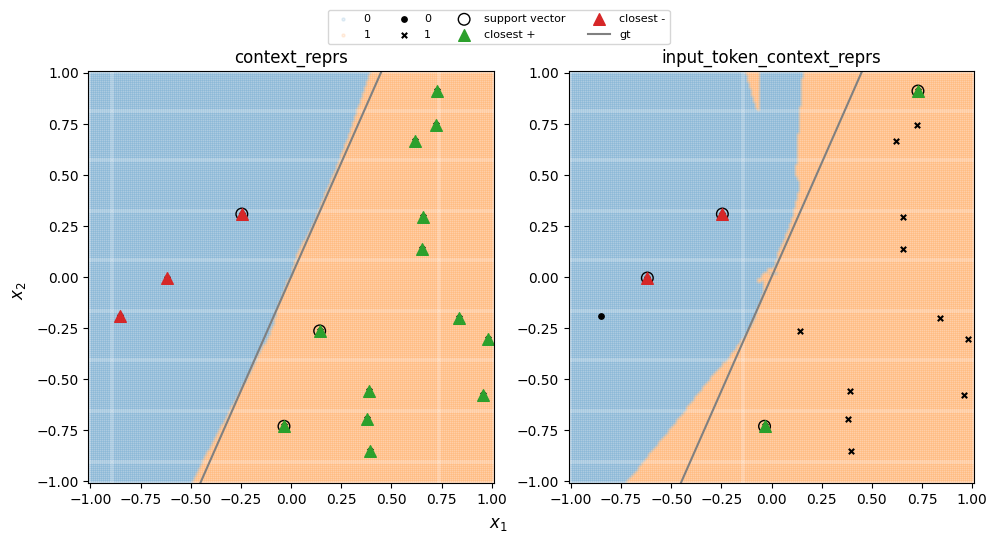

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[ -1.           5.85268697 -19.53278852  -1.           1.
  -1.           1.03857879  -1.          -3.2002965    1.
   1.         -26.4812558   -4.82990556  -9.21890018   1.
   1.        ]
[-1.          1.         -4.9106628  -5.80391892  5.33609542 -5.55657958
  5.27842435 -6.2089619  -6.09211926  5.05920586  5.45181209 -5.70704731
 -1.         -6.184964    4.68263585  5.43218951]


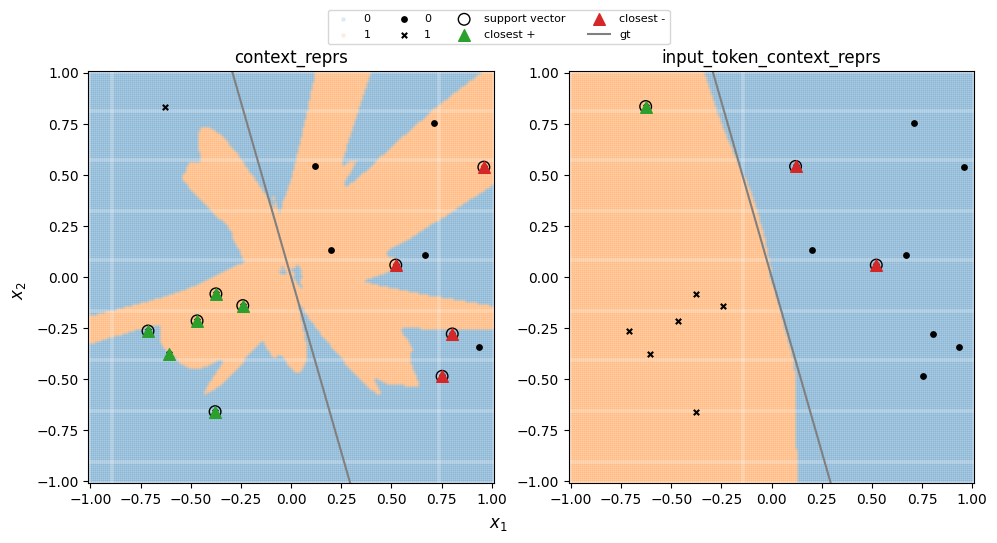

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[-1.         11.39883718 -1.          1.          1.          1.
  1.         -2.28362949 -1.          1.         -1.          1.
  1.         -1.         -1.90242994 -1.        ]
[-1.          1.         -1.02014722  1.          1.          1.17600244
  1.55355057 -1.16962671 -1.24265756  1.55803452 -1.          1.49002875
  1.45998605 -1.49399514 -1.30979026 -1.36650609]


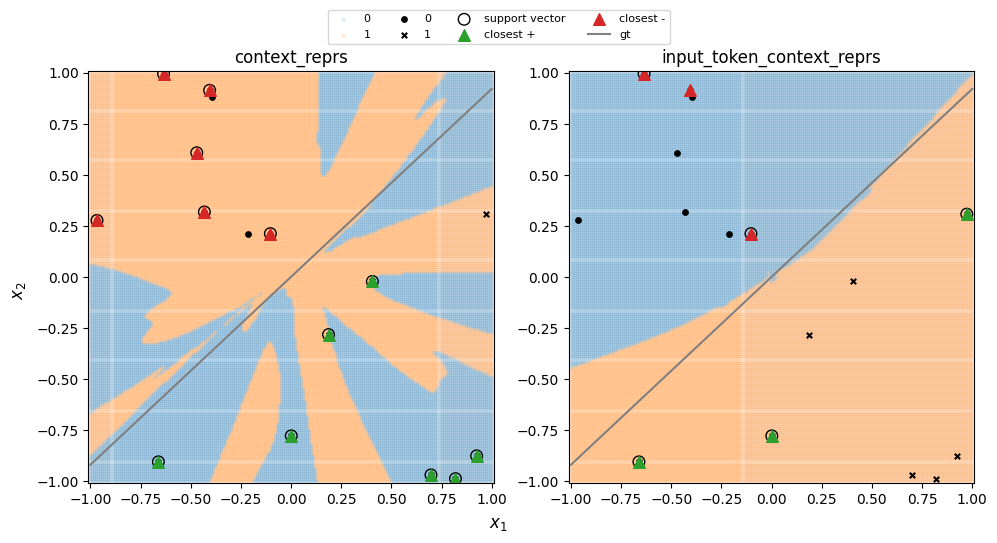

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[  1.           1.           1.           1.         -14.4770074
  -1.          -1.          -1.          -5.59244741   4.35507839
   7.39848411  -1.           7.39227706  -3.04695524   1.
   8.46421928]
[ 1.          1.          4.17927011  2.71390581 -1.23578518 -1.36852622
 -1.95625476 -1.39420875 -1.          3.94396611  2.86690754 -1.91882914
  3.44375549 -1.70123217  3.87981374  2.6568258 ]


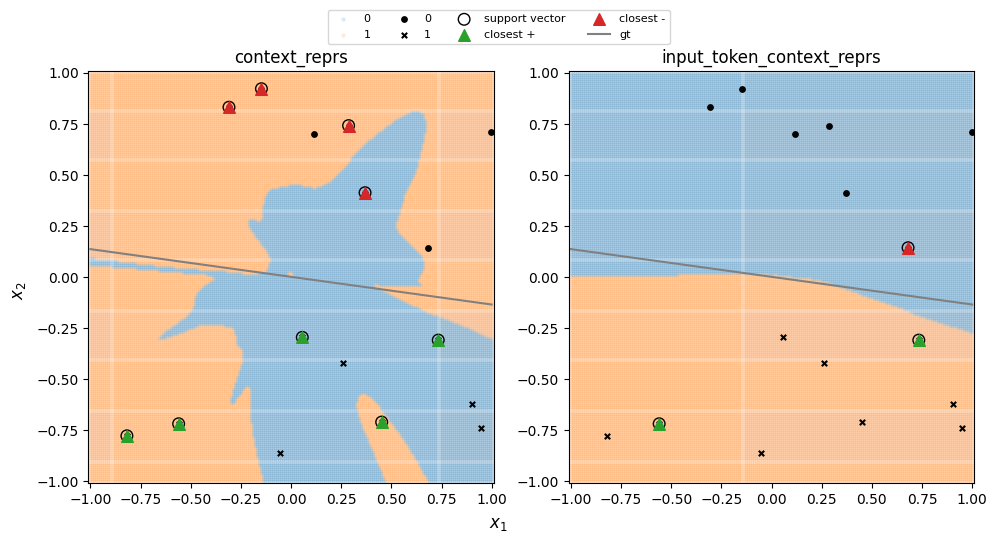

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
[  1.         340.19103163 123.69547652   1.           3.42131406
  -1.          -1.           1.          -5.42070152  -1.
   1.         171.80328335 343.19539694 332.2591804    1.
 348.59771957]
[ 1.          2.22604829  1.21872118  1.9206801   2.35669654 -1.
 -1.00985052  2.31235208 -1.         -1.00951615  2.36439679  2.25948717
  2.31825073  2.28992172  1.76432056  1.02919581]


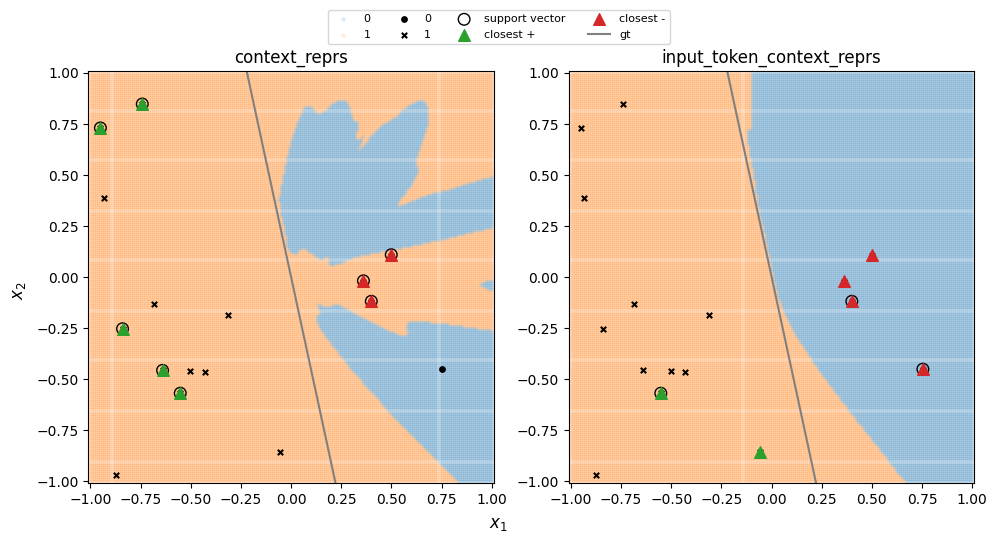

In [28]:
nrows = 1
ncols = 2
for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_repr in agent_reprs.items():
        print("Processing agent {}".format(agent_path))

        fig, axes = plt.subplots(
            nrows,
            ncols,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )
        query_input = agent_repr["query_reprs"][task_i]
        for ax_i, repr_key in enumerate(["context_reprs", "input_token_context_reprs"]):

            svm_primal = agent_reprs[agent_path]["svms"][task_i][repr_key]["primal"]["sol"]
            svm_db = -(np.array(input_range) * svm_primal[0] + svm_primal[2]) / svm_primal[1]

            primal_out = (np.array(agent_repr[repr_key][task_i]) @ svm_primal[:-1]) + svm_primal[-1]
            primal_constraints = 2 * (0.5 - (1 - train_y)) * primal_out
            print(primal_out)
            support_vectors = context_inputs[np.where(primal_constraints <= 1 + 1e-5)[0]]
            
            poss = np.where(primal_out > 0)[0]
            negs = np.where(primal_out < 0)[0]
            closest_pos_dist = np.min(primal_out[poss])
            closest_neg_dist = np.max(primal_out[negs])
            closest_pos = context_inputs[np.isclose(closest_pos_dist, primal_out, atol=0.1)]
            closest_neg = context_inputs[np.isclose(closest_neg_dist, primal_out, atol=0.1)]
            
            ax = axes[ax_i]
            params = agent_repr["svms"][task_i][repr_key]["primal"]["sol"]
            svm_preds = (
                (
                    np.array(query_input) @ params[:-1]
                    + params[-1:]
                )
                >= 0
            ).astype(int)
            
            for possible_label in [0, 1]:
                idxes = np.where(svm_preds == possible_label)
                ax.scatter(
                    gt["inputs"][idxes][:, 0],
                    gt["inputs"][idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=5,
                    alpha=0.1
                )
            for possible_label in [0, 1]:
                idxes = np.where(train_y == possible_label)
                ax.scatter(
                    context_inputs[idxes][:, 0],
                    context_inputs[idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=15,
                    marker="x" if possible_label else "o",
                    c="black"
                )

            ax.scatter(
                support_vectors[:, 0],
                support_vectors[:, 1],
                label=f"support vector" if ax_i == 0 else "",
                s=70,
                facecolors="none",
                edgecolors="black",
            )

            ax.scatter(
                closest_pos[:, 0],
                closest_pos[:, 1],
                label=f"closest +" if ax_i == 0 else "",
                s=70,
                marker="^"
            )

            ax.scatter(
                closest_neg[:, 0],
                closest_neg[:, 1],
                label=f"closest -" if ax_i == 0 else "",
                s=70,
                marker="^"
            )
            
            ax.plot(
                input_range,
                gt["decision_boundary"][task_i],
                color="gray",
                label="gt" if ax_i == 0 else ""
            )

            ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_title("{}".format(repr_key))
            ax.grid(False)

        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=4,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )
        fig.supxlabel("$x_1$")
        fig.supylabel("$x_2$")
        plt.show()

# Analyzing Support Vector from Transformer Embedding
Current observation:
- There does not seem to be gap in the classification, yet the context samples are classified incorrectly

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


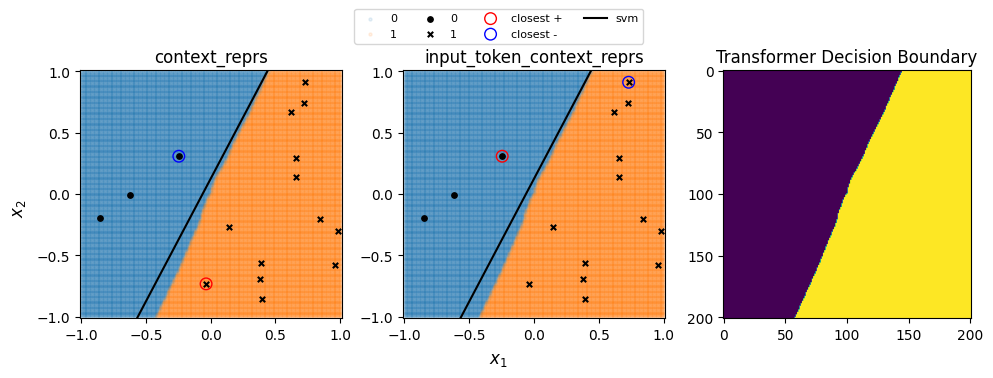

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


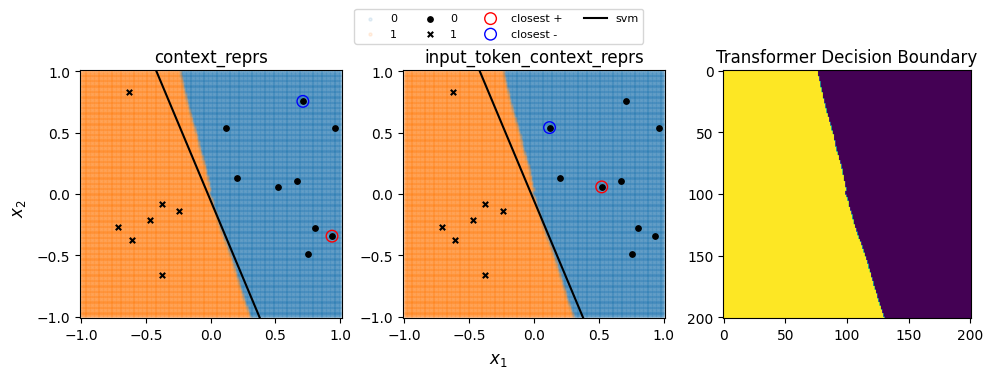

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


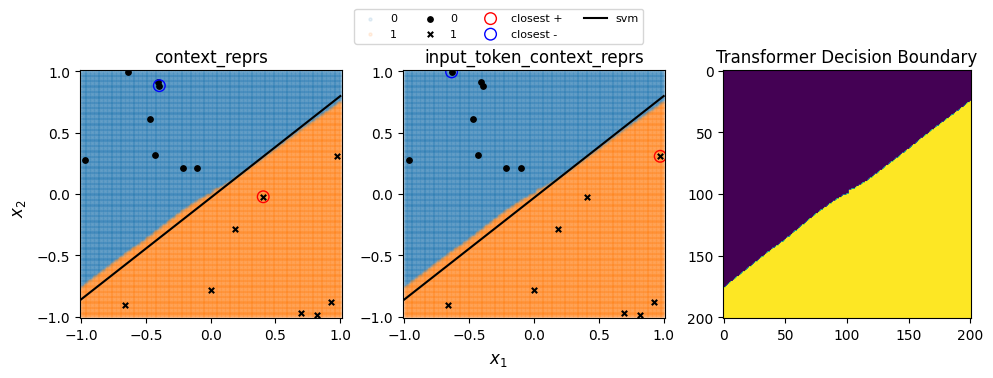

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


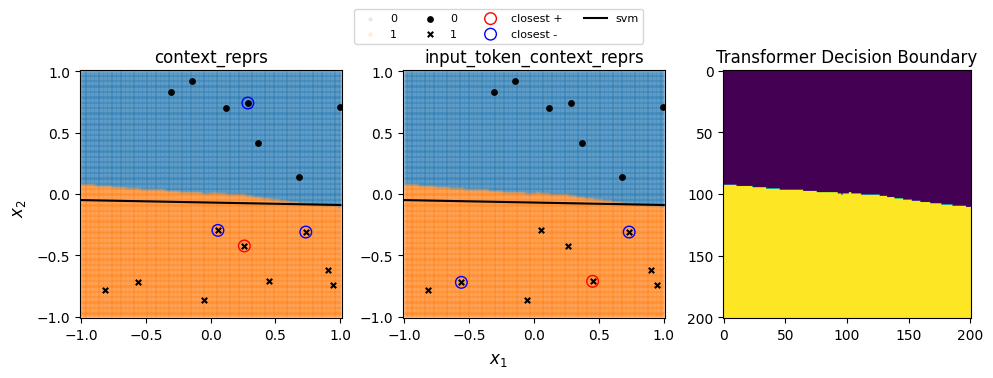

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9


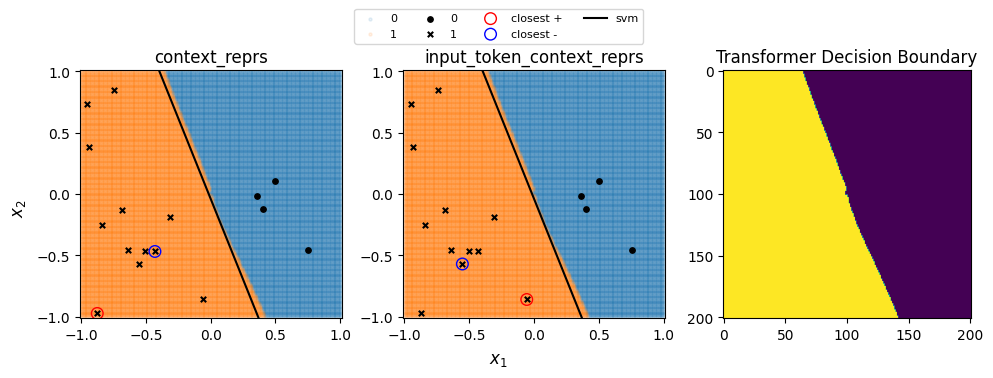

In [27]:
nrows = 1
ncols = 3
for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_repr in agent_reprs.items():
        print("Processing agent {}".format(agent_path))
        svm_primal = agent_reprs[agent_path]["svms"][task_i]["input"]["primal"]["sol"]
        svm_db = -(np.array(input_range) * svm_primal[0] + svm_primal[2]) / svm_primal[1]

        fig, axes = plt.subplots(
            nrows,
            ncols,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )
        
        per_task_results = agent_results[agent_path][task_i]
        one_hot_preds = per_task_results[np.max(list(per_task_results.keys()))]
        preds = np.argmax(one_hot_preds, axis=-1)
        
        axes[2].imshow(preds.reshape((201, 201))[::-1])
        axes[2].set_title("Transformer Decision Boundary")

        query_input = agent_repr["query_reprs"][task_i]
        for ax_i, repr_key in enumerate(["context_reprs", "input_token_context_reprs"]):

            embed_first_dim = np.array(agent_reprs[agent_path][repr_key][task_i])[:, 0]
            
            poss = np.where(embed_first_dim > 0)[0]
            negs = np.where(embed_first_dim < 0)[0]
            closest_pos_dist = np.min(embed_first_dim[poss])
            closest_neg_dist = np.max(embed_first_dim[negs])
            closest_pos = context_inputs[np.isclose(closest_pos_dist, embed_first_dim, atol=0.1)]
            closest_neg = context_inputs[np.isclose(closest_neg_dist, embed_first_dim, atol=0.1)]
            
            ax = axes[ax_i]
            
            for possible_label in [0, 1]:
                idxes = np.where(preds == possible_label)
                ax.scatter(
                    gt["inputs"][idxes][:, 0],
                    gt["inputs"][idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=5,
                    alpha=0.1
                )
            for possible_label in [0, 1]:
                idxes = np.where(train_y == possible_label)
                ax.scatter(
                    context_inputs[idxes][:, 0],
                    context_inputs[idxes][:, 1],
                    label=f"{possible_label}" if ax_i == 0 else "",
                    s=15,
                    marker="x" if possible_label else "o",
                    c="black"
                )

            ax.scatter(
                closest_pos[:, 0],
                closest_pos[:, 1],
                label=f"closest +" if ax_i == 0 else "",
                s=70,
                facecolors="none",
                edgecolors="red",
            )

            ax.scatter(
                closest_neg[:, 0],
                closest_neg[:, 1],
                label=f"closest -" if ax_i == 0 else "",
                s=70,
                facecolors="none",
                edgecolors="blue",
            )
            
            ax.plot(
                input_range,
                svm_db,
                color="black",
                label="svm" if ax_i == 0 else ""
            )

            ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
            ax.set_title("{}".format(repr_key))
            ax.grid(False)

        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=4,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )
        fig.supxlabel("$x_1$")
        fig.supylabel("$x_2$")
        plt.show()

# Permutation Experiment
- Permute -> embed
- Embed -> permute

Expectation: If the transformer end up being permutation invariant, then the first dimension of the representation space should be the same under the permutation of two operations.

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
(2, 2) (3, 2)
[ 11.97791   -13.003762   12.963434   13.139663   12.0962305  13.089842
  12.561837   12.887841   13.116992   12.970513   13.080241   12.885488
 -13.271643   11.540589   12.569851  -13.222025 ]
context_reprs - Permutation False - In-context Prediction Accuracy: 100.0%
(2, 2) (3, 2)
[ 13.038399   12.863249   12.069526   13.186856   12.967689   12.853096
  12.97365    13.2019415  13.040239  -13.212764  -13.323086  -12.990007
  12.929422   12.398405   12.790997   12.671738 ]
context_reprs - Permutation True - In-context Prediction Accuracy: 62.5%
(1, 2) (1, 2)
[ -1.1508385    0.30646908  12.034671    10.665947    11.876354
  12.422912    12.649312    12.806359    12.924772    12.316467
  12.389357    12.192439   -12.960318     2.2444177   12.677453
 -13.0627365 ]
input_token_context_reprs - Permutation False - In-c

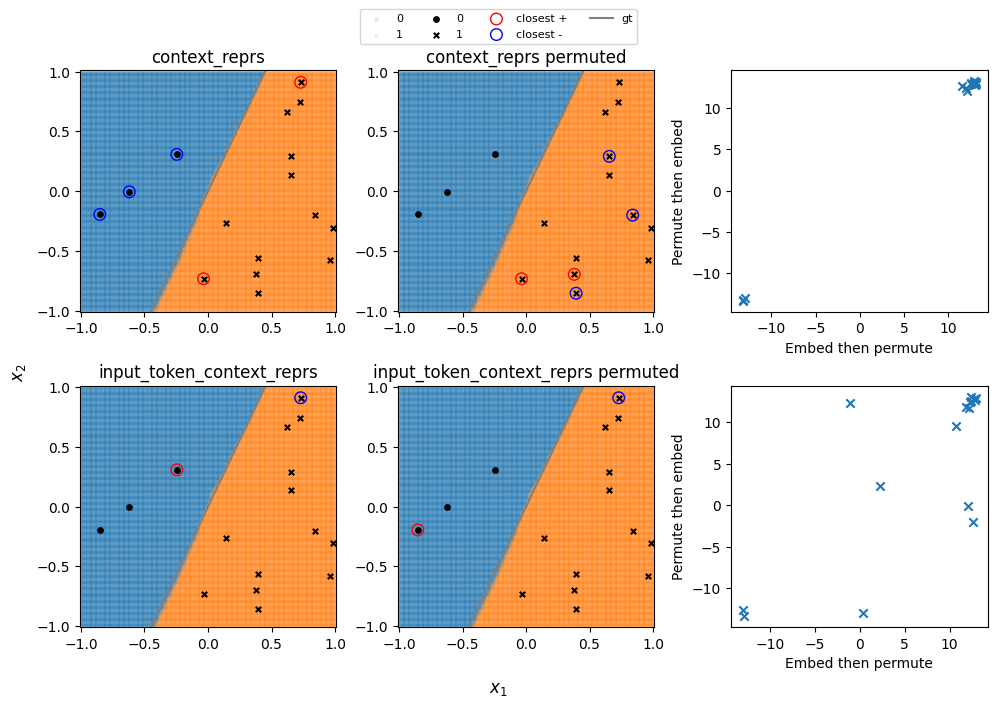

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
(2, 2) (1, 2)
[-12.809766   12.24771    -8.797624  -13.068483  -12.228094  -13.164399
 -12.913811  -12.744263  -13.084949  -12.833409  -13.194268   -1.7880627
  13.391449   12.090567  -12.922122   13.064122 ]
context_reprs - Permutation False - In-context Prediction Accuracy: 56.25%
(1, 2) (1, 2)
[ -7.986252  -12.841489  -12.326528  -13.051832  -13.172101  -13.129705
  -1.4413425 -12.91481   -12.887408   13.1381     13.416938   12.213934
 -12.692447  -12.819603  -13.2037735  11.678562 ]
context_reprs - Permutation True - In-context Prediction Accuracy: 68.75%
(1, 2) (1, 2)
[  0.03968848   1.7857765  -10.598836   -12.869954    12.917426
 -12.109424    13.152973   -12.947702   -13.059837    12.501891
  13.092614   -12.7234955   -0.6429123  -12.962855    12.767411
  12.931104  ]
input_token_context_reprs - Permutation False - In

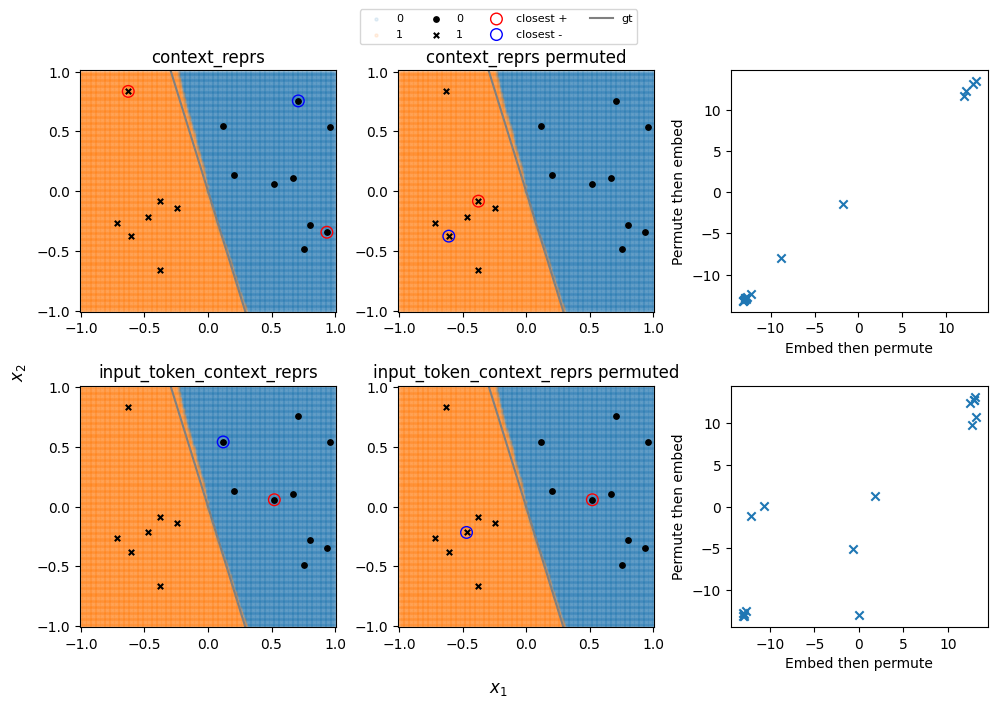

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
(1, 2) (1, 2)
[-12.433563  -12.815874   13.128219   11.196542   12.205573   13.101441
 -11.575928   12.891611   13.119268   10.156301   12.961805   13.246455
 -13.006944   12.339975  -10.3495455 -11.090827 ]
context_reprs - Permutation False - In-context Prediction Accuracy: 50.0%
(1, 2) (2, 2)
[ 13.065441 -12.025395  12.107016  11.348228  13.15087   11.609008
  13.21095   10.146934 -10.78304  -10.883659 -12.928265 -12.766918
  12.796125 -12.672448  13.00893   12.215439]
context_reprs - Permutation True - In-context Prediction Accuracy: 50.0%
(1, 2) (2, 2)
[ -0.01600975   0.7127062   -9.539882    -0.14516726  12.041332
  11.746529    12.68719    -12.324537   -12.928774    12.512529
 -12.342958    13.143139    13.019149   -13.231797   -13.083031
 -13.052742  ]
input_token_context_reprs - Permutation False - In-context Predicti

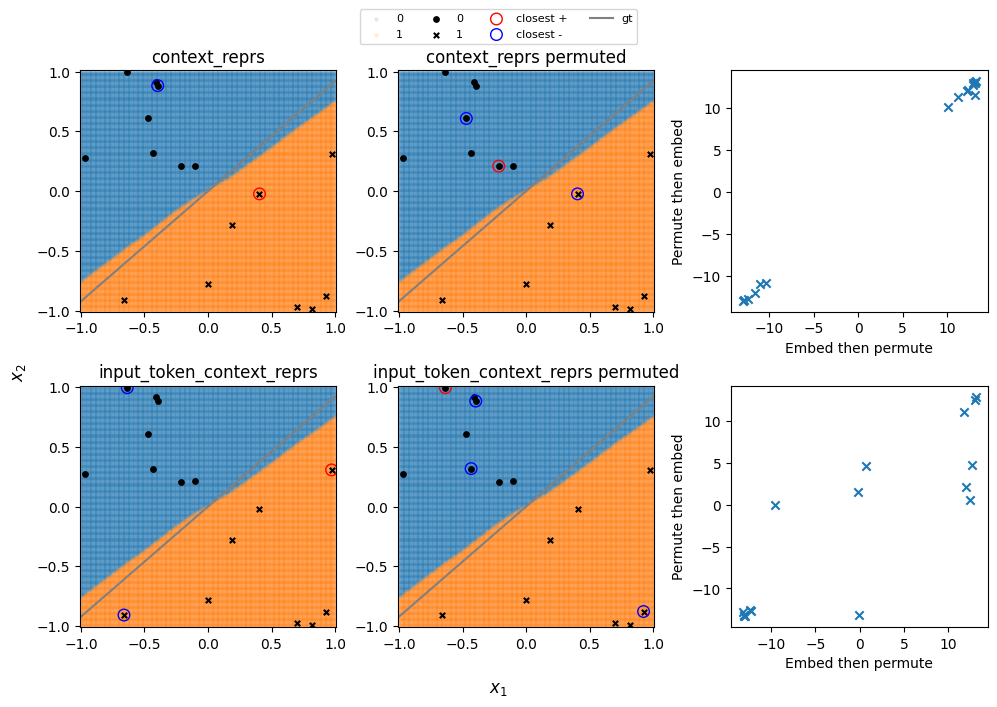

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
(2, 2) (6, 2)
[-12.932737 -12.762146  13.043766 -13.079301  11.431589   8.655016
 -12.816059  12.82639   11.816599 -13.023435   5.351063  13.140662
   4.940993  13.148468 -12.829586  12.020435]
context_reprs - Permutation False - In-context Prediction Accuracy: 31.25%
(1, 2) (6, 2)
[ 13.034473  -12.820527   11.486256  -13.04652     8.61384    11.517538
  13.143479  -13.028386  -12.845276   11.282586    3.744076  -12.654802
  12.785381  -12.892623    5.2970033  13.200482 ]
context_reprs - Permutation True - In-context Prediction Accuracy: 68.75%
(1, 2) (3, 2)
[ -0.11741804  -0.17378831  12.512872     9.756181    -9.5235815
 -12.607485   -13.17779    -12.806256    -0.60260415  13.097386
  12.356156   -13.231564    12.152126   -13.1939535   11.8456135
  12.243774  ]
input_token_context_reprs - Permutation False - In-context Pred

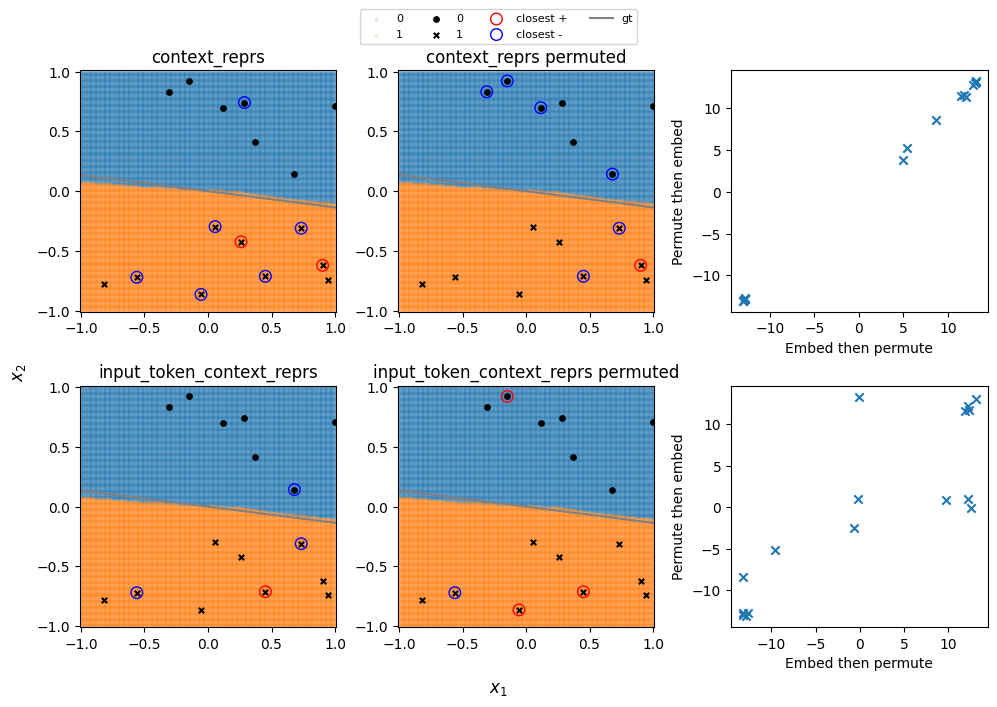

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
(1, 2) (1, 2)
[-12.968269   11.9697895  -4.502902  -12.804084  -11.854963  -12.851545
 -12.935139  -12.125346  -12.82835   -12.875777  -12.815111   -1.3219438
  12.950082   11.436182  -12.950134   13.1202   ]
context_reprs - Permutation False - In-context Prediction Accuracy: 50.0%
(1, 2) (1, 2)
[ -5.0552797 -12.822903  -11.9385805 -12.801241  -13.018347  -12.840214
  -1.399108  -12.801389  -12.826977   13.475812   13.295413   11.97263
 -12.3043    -12.885994  -13.004822   11.455991 ]
context_reprs - Permutation True - In-context Prediction Accuracy: 37.5%
(1, 2) (1, 2)
[ -0.1156375   12.213855     2.331251     8.3567505   13.267216
 -12.670478   -12.932204    12.519285   -12.865184   -12.523166
  13.310065    12.264667    12.785034    11.994985     7.393127
   0.41164201]
input_token_context_reprs - Permutation False - In-co

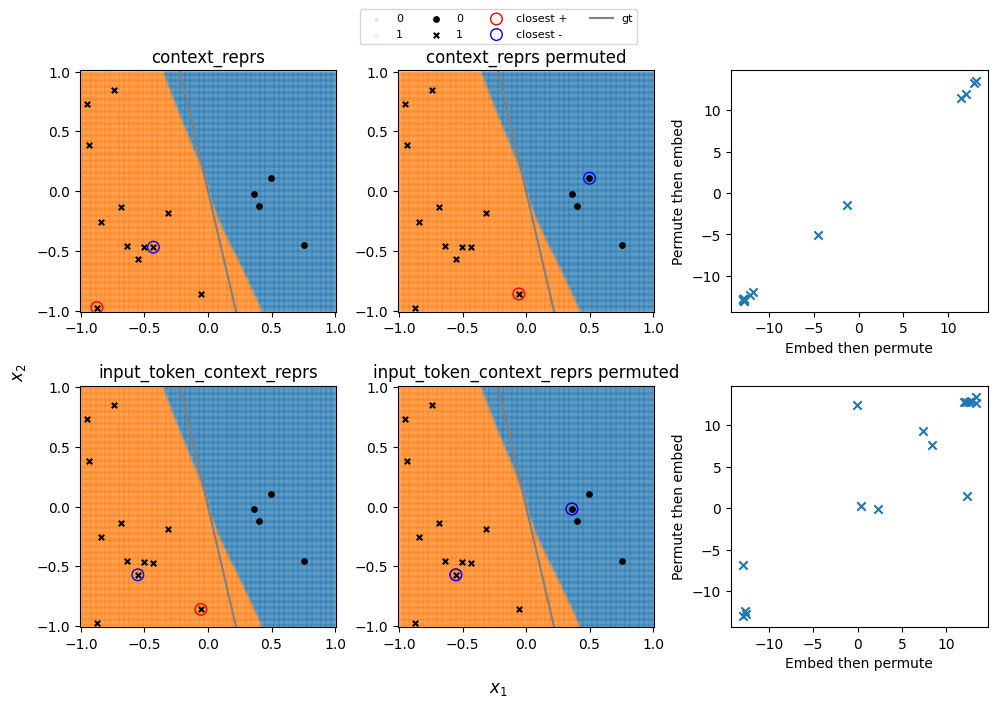

In [26]:
nrows = 2
ncols = 3
for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_repr in agent_reprs.items():
        print("Processing agent {}".format(agent_path))

        fig, axes = plt.subplots(
            nrows,
            ncols,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )
        
        per_task_results = agent_results[agent_path][task_i]
        one_hot_preds = per_task_results[np.max(list(per_task_results.keys()))]
        preds = np.argmax(one_hot_preds, axis=-1)

        query_input = agent_repr["query_reprs"][task_i]
        for ax_i, repr_key in enumerate(["context_reprs", "input_token_context_reprs"]):

            ax = axes[ax_i, 2]
            permute_idxes = np.array(agent_reprs[agent_path]["permutation"][repr_key][task_i]["permute_idxes"])
            ax.scatter(
                np.array(agent_reprs[agent_path][repr_key][task_i])[:, [0]][permute_idxes],
                np.array(agent_reprs[agent_path]["permutation"][repr_key][task_i]["repr"])[:, [0]],
                marker="x"
            )
            ax.set_xlabel("Embed then permute")
            ax.set_ylabel("Permute then embed")

            for ii, is_permute in enumerate((False, True)):
                if is_permute:
                    embed_first_dim = np.array(agent_reprs[agent_path]["permutation"][repr_key][task_i]["repr"])[:, 0]
                else:
                    embed_first_dim = np.array(agent_reprs[agent_path][repr_key][task_i])[:, 0]
                
                poss = np.where(embed_first_dim > 0)[0]
                negs = np.where(embed_first_dim < 0)[0]
                closest_pos_dist = np.min(embed_first_dim[poss])
                closest_neg_dist = np.max(embed_first_dim[negs])
                closest_pos = context_inputs[np.isclose(closest_pos_dist, embed_first_dim, atol=0.1)]
                closest_neg = context_inputs[np.isclose(closest_neg_dist, embed_first_dim, atol=0.1)]
                
                ax = axes[ax_i, ii]

                print("{} - Permutation {} - In-context Prediction Accuracy: {}%".format(
                    repr_key,
                    is_permute,
                    np.mean((jax.nn.sigmoid(embed_first_dim) >= 0.5) == train_y) * 100
                ))
                
                for possible_label in [0, 1]:
                    idxes = np.where(preds == possible_label)
                    ax.scatter(
                        gt["inputs"][idxes][:, 0],
                        gt["inputs"][idxes][:, 1],
                        label=f"{possible_label}" if ax_i + ii == 0 else "",
                        s=5,
                        alpha=0.1
                    )
                for possible_label in [0, 1]:
                    idxes = np.where(train_y == possible_label)
                    ax.scatter(
                        context_inputs[idxes][:, 0],
                        context_inputs[idxes][:, 1],
                        label=f"{possible_label}" if ax_i + ii == 0 else "",
                        s=15,
                        marker="x" if possible_label else "o",
                        c="black"
                    )

                ax.scatter(
                    closest_pos[:, 0],
                    closest_pos[:, 1],
                    label=f"closest +" if ax_i + ii == 0 else "",
                    s=70,
                    facecolors="none",
                    edgecolors="red",
                )

                ax.scatter(
                    closest_neg[:, 0],
                    closest_neg[:, 1],
                    label=f"closest -" if ax_i + ii == 0 else "",
                    s=70,
                    facecolors="none",
                    edgecolors="blue",
                )
                
                ax.plot(
                    input_range,
                    gt["decision_boundary"][task_i],
                    color="gray",
                    label="gt" if ax_i + ii == 0 else ""
                )

                ax.set_xlim(input_range[0] - 0.01, input_range[1] + 0.01)
                ax.set_ylim(input_range[0] - 0.01, input_range[1] + 0.01)
                ax.set_title("{}{}".format(repr_key, " permuted" if is_permute else ""))
                ax.grid(False)

        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=4,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8",
        )
        fig.supxlabel("$x_1$")
        fig.supylabel("$x_2$")
        plt.show()

# Analyzing Dual

In [7]:
import cvxpy as cp

def recover_dual_from_primal(primal_sol, train_x, train_y):
    assert len(train_x.shape) == 2
    assert len(train_y.shape) == 1

    N, _ = train_x.shape

    print("Primal solution: {}, shape: {}".format(primal_sol, primal_sol.shape))

    primal_out = (train_x @ primal_sol[:-1]) + primal_sol[-1]
    primal_constraints = 2 * (0.5 - (1 - train_y)) * primal_out
    coefs = 1 - primal_constraints
    coefs[np.isclose(coefs, 0)] = 0
    G = np.eye(N)
    h = np.zeros(N)
    dual_var = cp.Variable(N)
    prob = cp.Problem(
        cp.Maximize(coefs.T @ dual_var),
        [G @ dual_var >= h],
    )
    loss = 0.5 * (np.linalg.norm(primal_sol[:-1]) ** 2) + prob.solve(verbose=False)
    alphas = dual_var.value
    return loss, alphas

In [8]:
from pprint import pprint

for task_i in context_data:
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    for agent_path, agent_repr in agent_reprs.items():

        print("=" * 50)
        print("Processing agent {}".format(agent_path))
        print("-" * 50)
        print("input ")
        print("-" * 50)
        # pprint(agent_repr["svms"][task_i]["input"]["dual"])
        loss, alphas = recover_dual_from_primal(
            agent_repr["svms"][task_i]["input"]["primal"]["sol"],
            context_inputs,
            train_y
        )
        # pprint({
        #     "loss": loss,
        #     "sol": alphas,
        # })
        # print(np.argsort(agent_repr["svms"][task_i]["input"]["dual"]["sol"]))
        sort_idxes = np.argsort(alphas)
        print("Primal loss: {}, Dual loss: {}".format(
            agent_repr["svms"][task_i]["input"]["primal"]["loss"],
            loss
        ))
        print("Dual solution (sorted): {}".format(alphas[sort_idxes]))
        print("Sort indices: {}".format(sort_idxes))
        for repr_key in ["context_reprs", "input_token_context_reprs"]:
            print("-" * 50)
            print(repr_key)
            print("-" * 50)
            # pprint(agent_repr["svms"][task_i][repr_key]["dual"])
            loss, alphas = recover_dual_from_primal(
                np.array(agent_repr["svms"][task_i][repr_key]["primal"]["sol"]),
                np.array(agent_repr[repr_key][task_i]),
                train_y
            )
            # pprint({
            #     "loss": loss,
            #     "sol": alphas,
            # })
            # print(np.argsort(agent_repr["svms"][task_i][repr_key]["dual"]["sol"]))
            sort_idxes = np.argsort(alphas)
            print("Primal loss: {}, Dual loss: {}".format(
                agent_repr["svms"][task_i][repr_key]["primal"]["loss"],
                loss
            ))
            print("Dual solution (sorted): {}".format(alphas[sort_idxes]))
            print("Sort indices: {}".format(sort_idxes))
        print("")

Processing agent /home/bryanpu1/projects/jaxl/jaxl/logs/icl-sigmoid_bce-context_len_16-num_blocks_8/one_hot-10-07-23_10_46_11-22362b3d-0b55-4c9f-af72-982e364d61a9
--------------------------------------------------
input 
--------------------------------------------------
Primal solution: [ 2.96701743 -1.4816148   0.18421131], shape: (3,)
Primal loss: 5.499187435901053, Dual loss: 5.4991874359342106
Dual solution (sorted): [-1.40469637e-11 -1.37844958e-11 -1.30339315e-11 -1.26493508e-11
 -1.20672901e-11 -1.13076241e-11 -9.98446428e-12 -7.89294645e-12
 -2.39869593e-12 -4.66514145e-13  8.52878333e-11  1.90551553e-10
  2.29232140e-09  5.83487536e-01  5.83487536e-01  5.83487536e-01]
Sort indices: [10 11  5  2  8  7 15  3  9 12 14 13  6  0  1  4]
--------------------------------------------------
context_reprs
--------------------------------------------------
Primal solution: [ 0.07869916  0.00300341  0.00166914 -0.00274494  0.0011076  -0.00335776
  0.00095633 -0.000726    0.00312125 -0.004